In [1]:
import psycopg2
# import jsonlines
# import networkx as nx
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from dotenv import load_dotenv
import os
from matplotlib.ticker import StrMethodFormatter

In [2]:
# Load environment variables from .env file
load_dotenv(dotenv_path='/home/matija/cardano-viz-practice/backend/backend/.env')

True

In [3]:
conn = psycopg2.connect(database=os.getenv('DB_CARDANO_NAME'), user=os.getenv('DB_CARDANO_USER'), password=os.getenv('DB_CARDANO_PASSWORD'), host=os.getenv('DB_CARDANO_HOST'), port="5432")

In [27]:
conn.rollback()

In [4]:
cur = conn.cursor()

In [20]:
def epoch_to_datetime(epoch_no):
    # Cardano epoch starts on 2017-09-23
    epoch_start = pd.Timestamp('2017-09-23')
    # Each epoch is 5 days long
    epoch_duration = pd.Timedelta(days=5)
    return epoch_start + (epoch_no * epoch_duration)

<h2>Epochs and their dates</h2>

In [7]:
cur.execute("SELECT no as epoch, start_time FROM epoch ORDER BY no;")

In [8]:
epochs_dates = pd.DataFrame(cur.fetchall(), columns=['epoch', 'start_time'])
epochs_dates_fil = epochs_dates.iloc[1:-1]

<h2>Number of stake pools over epochs</h2>

In [50]:
cur.execute("SELECT epoch_no, count(pool_id) AS pool_count FROM pool_stats_summary GROUP BY epoch_no ORDER BY epoch_no;")

In [51]:
stake_pools = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'pool_count'])
# stake_pools["start"] = pd.epoch_to_datetime(stake_pools['epoch_no'])
stake_pools_fil = stake_pools.iloc[1:-1]

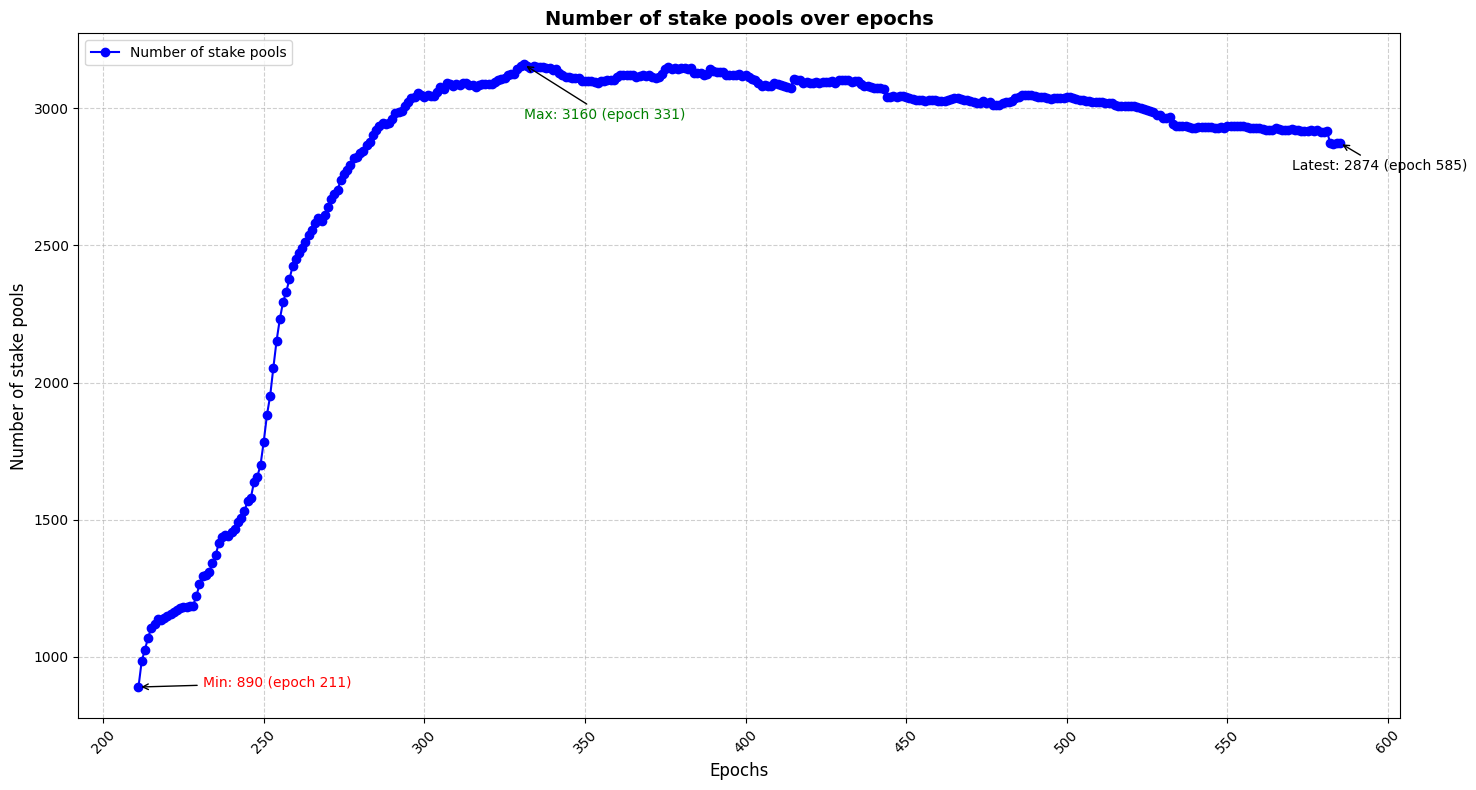

In [ ]:
plt.figure(figsize=(15, 8))

plt.plot(stake_pools_fil['epoch_no'], stake_pools_fil['pool_count'], marker='o', linestyle='-', label='Number of stake pools', color='blue')

max_pool_count = stake_pools_fil['pool_count'].max()
max_pool_count_epoch = stake_pools_fil.loc[stake_pools_fil['pool_count'].idxmax(), 'epoch_no']

plt.annotate(f'Max: {max_pool_count:,} (epoch {max_pool_count_epoch})',
             xy=(max_pool_count_epoch, max_pool_count), 
             xytext=(max_pool_count_epoch, max_pool_count-200),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=10, color='green')

min_pool_count = stake_pools_fil['pool_count'].min()
min_pool_count_epoch = stake_pools_fil.loc[stake_pools_fil['pool_count'].idxmin(), 'epoch_no']

plt.annotate(f'Min: {min_pool_count} (epoch {min_pool_count_epoch})',
             xy=(min_pool_count_epoch, min_pool_count), 
             xytext=(min_pool_count_epoch+20, min_pool_count),  
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=10, color='red')

current_pool_count = stake_pools_fil.loc[stake_pools_fil['epoch_no'].idxmax(), 'pool_count']
current_pool_count_epoch = stake_pools_fil['epoch_no'].max()

plt.annotate(f'Latest: {current_pool_count:,} (epoch {current_pool_count_epoch})',
             xy=(current_pool_count_epoch, current_pool_count), 
             xytext=(current_pool_count_epoch-15, current_pool_count-100),  
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='black')

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Number of stake pools', fontsize=12)
plt.title('Number of stake pools over epochs', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
cur.execute("""
SELECT
    e.no AS epoch_no,
    e.start_time AS start_time,     
    COUNT(DISTINCT pu.hash_id) AS pools_count
FROM epoch e
JOIN pool_update pu
    ON pu.active_epoch_no <= e.no
LEFT JOIN pool_retire pr
    ON pr.hash_id = pu.hash_id
    AND pr.retiring_epoch <= e.no
WHERE pr.id IS NULL
GROUP BY e.no, e.start_time
ORDER BY e.no;
            """)

In [5]:
cur.execute("select epoch_no-1 as epoch_no, count(distinct pool_id) as pool_count from epoch_stake group by epoch_no order by epoch_no;")

In [6]:
stake_pools = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'pool_count'])
# stake_pools['start_time'] = stake_pools['start_time'].to_datetime()
# stake_pools["start"] = pd.epoch_to_datetime(stake_pools['epoch_no'])
stake_pools_fil = stake_pools.iloc[1:-1]

In [46]:
datatypes = stake_pools.dtypes

In [47]:
print(datatypes)

epoch_no      object
start_time    object
pool_count    object
dtype: object


In [38]:
labels = [f"{e}\n({d})" for e, d in zip(stake_pools_fil['epoch_no'], stake_pools_fil['start_time'])]

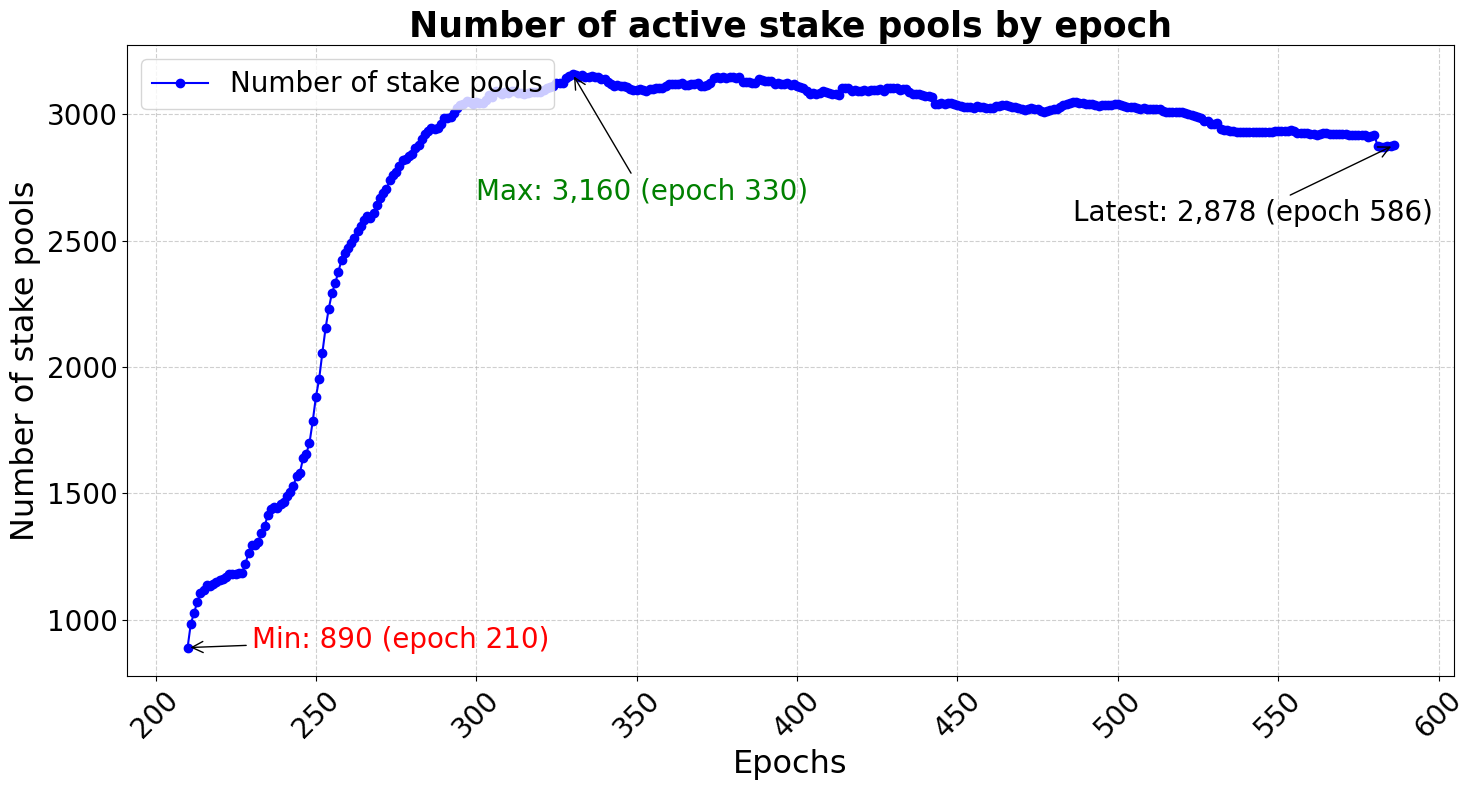

In [52]:
plt.figure(figsize=(15, 8))

plt.plot(stake_pools_fil['epoch_no'], stake_pools_fil['pool_count'], marker='o', linestyle='-', label='Number of stake pools', color='blue')

max_pool_count = stake_pools_fil['pool_count'].max()
max_pool_count_epoch = stake_pools_fil.loc[stake_pools_fil['pool_count'].idxmax(), 'epoch_no']

plt.annotate(f'Max: {max_pool_count:,} (epoch {max_pool_count_epoch})',
             xy=(max_pool_count_epoch, max_pool_count), 
             xytext=(max_pool_count_epoch-30, max_pool_count-500),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')

min_pool_count = stake_pools_fil['pool_count'].min()
min_pool_count_epoch = stake_pools_fil.loc[stake_pools_fil['pool_count'].idxmin(), 'epoch_no']

plt.annotate(f'Min: {min_pool_count} (epoch {min_pool_count_epoch})',
             xy=(min_pool_count_epoch, min_pool_count), 
             xytext=(min_pool_count_epoch+20, min_pool_count),  
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=20, color='red')

current_pool_count = stake_pools_fil.loc[stake_pools_fil['epoch_no'].idxmax(), 'pool_count']
current_pool_count_epoch = stake_pools_fil['epoch_no'].max()

plt.annotate(f'Latest: {current_pool_count:,} (epoch {current_pool_count_epoch})',
             xy=(current_pool_count_epoch, current_pool_count), 
             xytext=(current_pool_count_epoch-100, current_pool_count-300),  
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')

plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 

plt.xlabel('Epochs', fontsize=23)
plt.ylabel('Number of stake pools', fontsize=23)
plt.title('Number of active stake pools by epoch', fontsize=25, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
cur.execute(
    """WITH active AS (
    SELECT
        b.epoch_no AS epoch,
        COUNT(DISTINCT b.slot_leader_id) AS block_producing_pools
    FROM block b
    GROUP BY b.epoch_no
),
registered AS (
    SELECT
        e.no AS epoch,
        COUNT(pu.id) AS total_pools
    FROM epoch e
    LEFT JOIN pool_update pu
        ON pu.registered_tx_id IN (
            SELECT id FROM tx WHERE block_id IN (
                SELECT id FROM block WHERE epoch_no <= e.no
            )
        )
    GROUP BY e.no
)
SELECT
    r.epoch,
    r.total_pools,
    a.block_producing_pools
FROM registered r
LEFT JOIN active a ON r.epoch = a.epoch
ORDER BY r.epoch;""")


<h2>Number of delegators over epochs</h2>

In [32]:
cur.execute("select epoch_no-1, count(distinct addr_id) as delegator_count from epoch_stake group by epoch_no order by epoch_no;")

In [7]:
cur.execute("SELECT earned_epoch-2 as epoch_no, count(addr_id) as delegator_count FROM reward GROUP BY earned_epoch ORDER BY epoch_no;")

In [33]:
delegator_count = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'delegator_count'])
delegator_count_fil = delegator_count.iloc[1:-1]

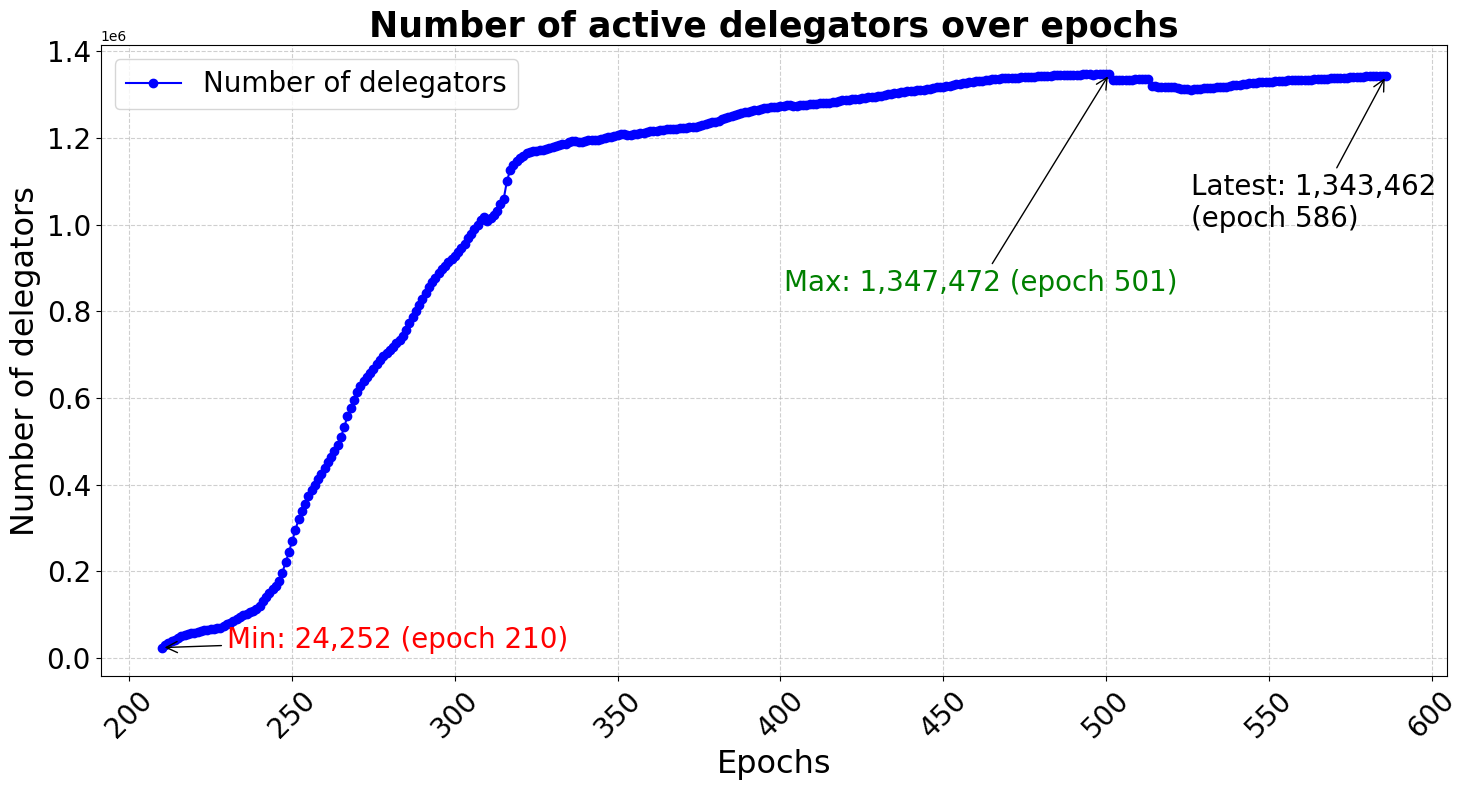

In [51]:
plt.figure(figsize=(15, 8))

plt.plot(delegator_count_fil['epoch_no'], delegator_count_fil['delegator_count'], marker='o', linestyle='-', label='Number of delegators', color='blue')

max_del_count = delegator_count_fil['delegator_count'].max()
max_del_count_epoch = delegator_count_fil.loc[delegator_count_fil['delegator_count'].idxmax(), 'epoch_no']

plt.annotate(f'Max: {max_del_count:,} (epoch {max_del_count_epoch})',
             xy=(max_del_count_epoch, max_del_count), 
             xytext=(max_del_count_epoch-100, max_del_count-500000),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')

min_del_count = delegator_count_fil['delegator_count'].min()
min_del_count_epoch = delegator_count_fil.loc[delegator_count_fil['delegator_count'].idxmin(), 'epoch_no']

plt.annotate(f'Min: {min_del_count:,} (epoch {min_del_count_epoch})',
             xy=(min_del_count_epoch, min_del_count), 
             xytext=(min_del_count_epoch+20, min_del_count),  
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=20, color='red')

current_pool_count = delegator_count_fil.loc[delegator_count_fil['epoch_no'].idxmax(), 'delegator_count']
current_pool_count_epoch = delegator_count_fil['epoch_no'].max()

plt.annotate(f'Latest: {current_pool_count:,} \n(epoch {current_pool_count_epoch})',
             xy=(current_pool_count_epoch, current_pool_count), 
             xytext=(current_pool_count_epoch-60, current_pool_count-350000),  
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')

plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 
# plt.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlabel('Epochs', fontsize=23)
plt.ylabel('Number of delegators', fontsize=23)
plt.title('Number of active delegators over epochs', fontsize=25, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

<h2>Total active stake over epochs</h2>

In [8]:
cur.execute("SELECT epoch_no, total_active_stake / 1000000 as total_active_stake FROM epoch_summary ORDER BY epoch_no;")

In [9]:
active_stake = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'total_active_stake'])
active_stake_fil = active_stake.iloc[1:-1]

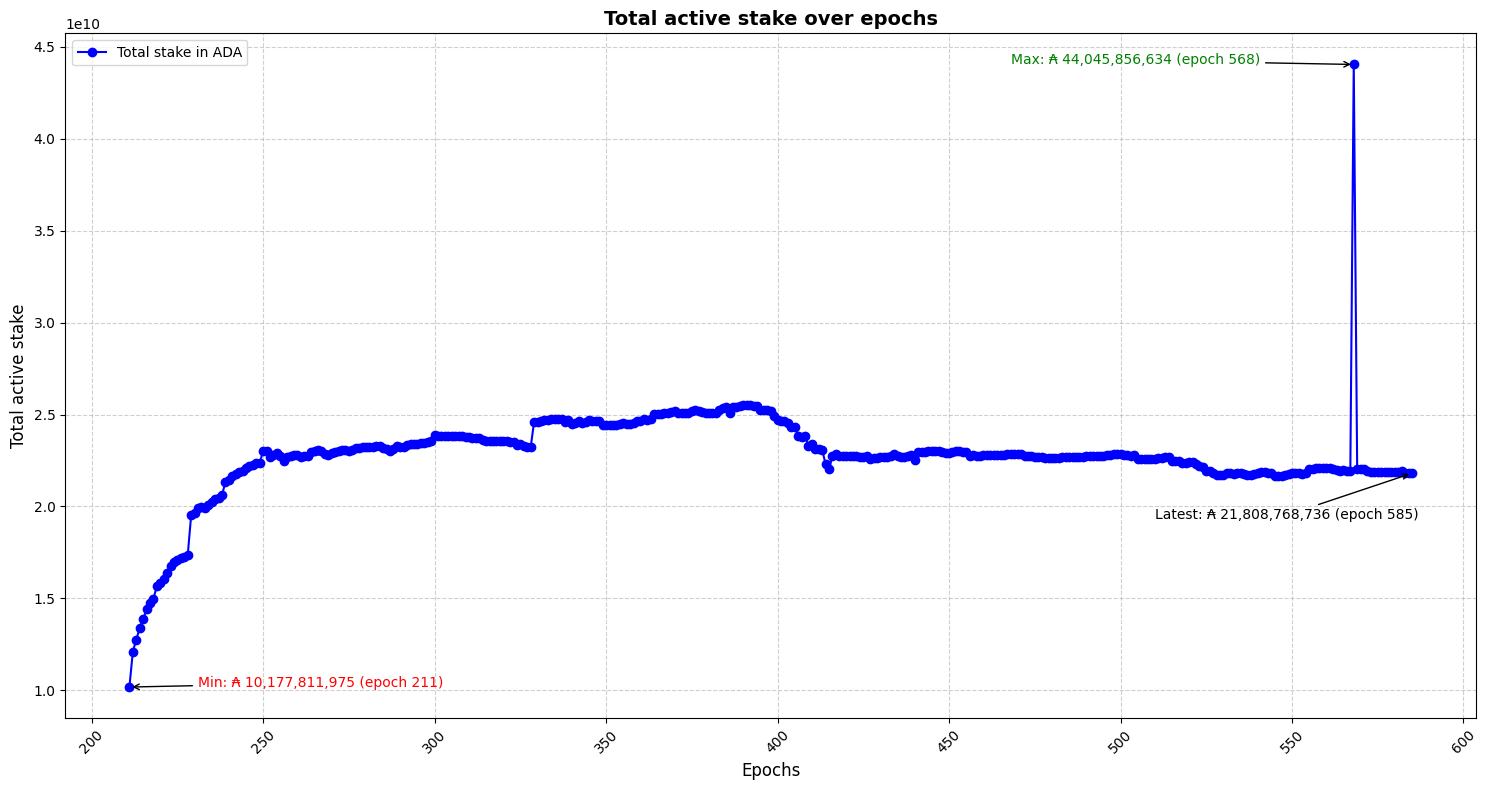

In [11]:
plt.figure(figsize=(15, 8))

plt.plot(active_stake_fil['epoch_no'], active_stake_fil['total_active_stake'], marker='o', linestyle='-', label='Total stake in ADA', color='blue')

max_active_stake = active_stake_fil['total_active_stake'].max()
max_active_stake_epoch = active_stake_fil.loc[active_stake_fil['total_active_stake'].idxmax(), 'epoch_no']

plt.annotate(f'Max: ₳ {round(max_active_stake):,} (epoch {max_active_stake_epoch})',
             xy=(max_active_stake_epoch, max_active_stake), 
             xytext=(max_active_stake_epoch-100, max_active_stake),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=10, color='green')

min_active_stake = active_stake_fil['total_active_stake'].min()
min_active_stake_epoch = active_stake_fil.loc[active_stake_fil['total_active_stake'].idxmin(), 'epoch_no']

plt.annotate(f'Min: ₳ {round(min_active_stake):,} (epoch {min_active_stake_epoch})',
             xy=(min_active_stake_epoch, min_active_stake), 
             xytext=(min_active_stake_epoch+20, min_active_stake),  
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=10, color='red')

current_active_stake = active_stake_fil.loc[active_stake_fil['epoch_no'].idxmax(), 'total_active_stake']
current_active_stake_epoch = active_stake_fil['epoch_no'].max()

plt.annotate(f'Latest: ₳ {round(current_active_stake):,} (epoch {current_active_stake_epoch})',
             xy=(current_active_stake_epoch, current_active_stake),
             xytext=(current_active_stake_epoch-75, current_active_stake-2500000000),  
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10, color='black')

plt.xticks(rotation=45) 
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Total active stake', fontsize=12)
plt.title('Total active stake over epochs', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [53]:
cur.execute("SELECT epoch_no-1 as epoch_no, sum(amount)/ 1000000 as total_active_stake FROM epoch_stake GROUP BY epoch_no ORDER BY epoch_no;")

In [54]:
active_stake = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'total_active_stake'])
active_stake_fil = active_stake.iloc[1:-1]

In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Herman Schaaf, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-18, License - CC BY-SA 4.0

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


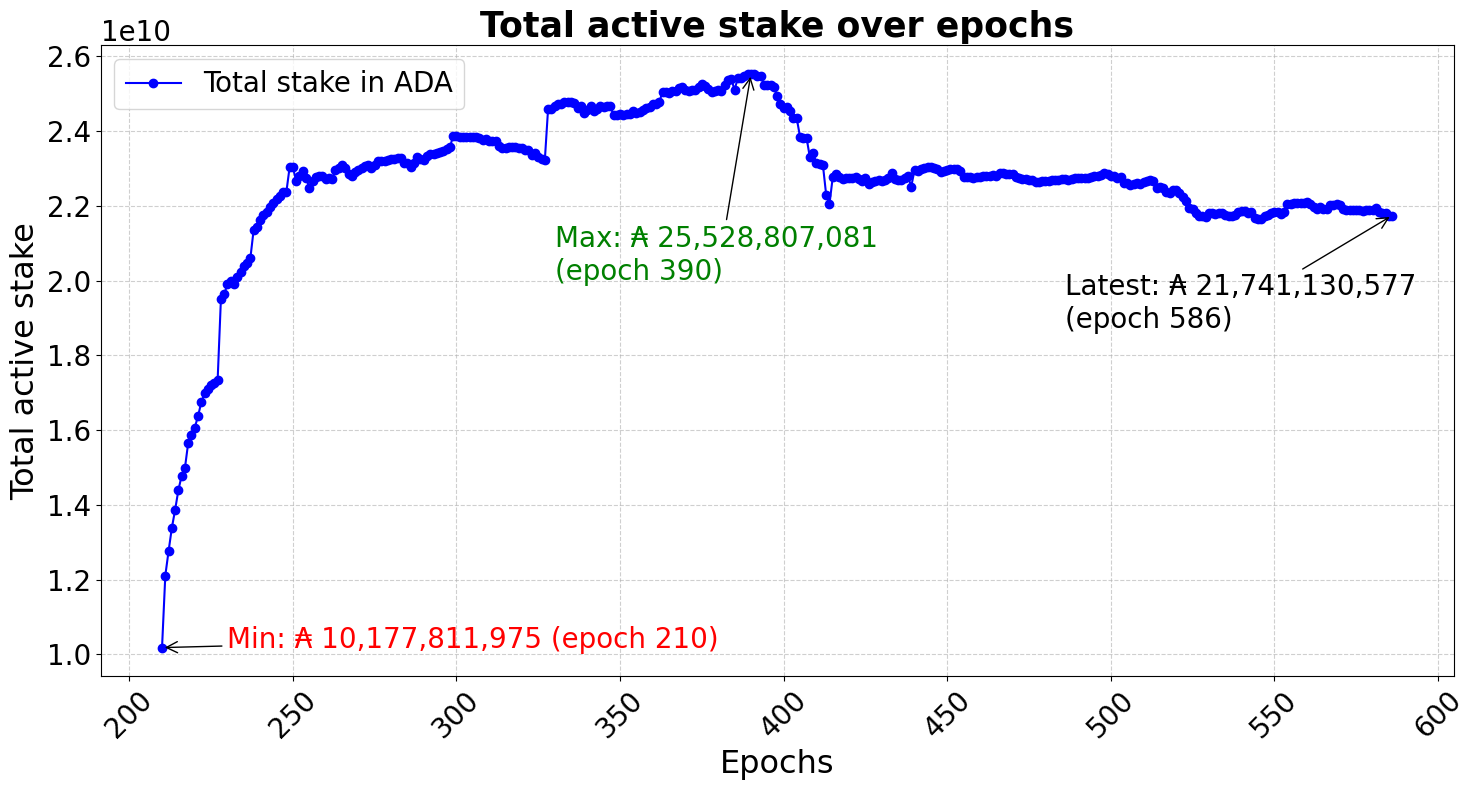

In [82]:
fix, ax = plt.subplots(figsize=(15, 8))

plt.plot(active_stake_fil['epoch_no'], active_stake_fil['total_active_stake'], marker='o', linestyle='-', label='Total stake in ADA', color='blue')

max_active_stake = active_stake_fil['total_active_stake'].max()
max_active_stake_epoch = active_stake_fil.loc[active_stake_fil['total_active_stake'].idxmax(), 'epoch_no']

plt.annotate(f'Max: ₳ {round(max_active_stake):,} \n(epoch {max_active_stake_epoch})',
             xy=(max_active_stake_epoch, max_active_stake), 
             xytext=(max_active_stake_epoch-60, max_active_stake-5500000000),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')

min_active_stake = active_stake_fil['total_active_stake'].min()
min_active_stake_epoch = active_stake_fil.loc[active_stake_fil['total_active_stake'].idxmin(), 'epoch_no']

plt.annotate(f'Min: ₳ {round(min_active_stake):,} (epoch {min_active_stake_epoch})',
             xy=(min_active_stake_epoch, min_active_stake), 
             xytext=(min_active_stake_epoch+20, min_active_stake),  
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=20, color='red')

current_active_stake = active_stake_fil.loc[active_stake_fil['epoch_no'].idxmax(), 'total_active_stake']
current_active_stake_epoch = active_stake_fil['epoch_no'].max()

plt.annotate(f'Latest: ₳ {round(current_active_stake):,} \n(epoch {current_active_stake_epoch})',
             xy=(current_active_stake_epoch, current_active_stake),
             xytext=(current_active_stake_epoch-100, current_active_stake-3000000000),  
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20, color='black')

plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.get_offset_text().set_fontsize(20)

plt.xlabel('Epochs', fontsize=23)
plt.ylabel('Total active stake', fontsize=23)
plt.title('Total active stake over epochs', fontsize=25, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

<h2>Total transactions and delegations over epoch</h2>

In [83]:
cur.execute("SELECT b.epoch_no, count(tx.id) as tx_count FROM tx JOIN block b ON b.id = tx.block_id WHERE b.epoch_no IS NOT NULL GROUP BY b.epoch_no;")

In [84]:
all_tx = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'tx_count'])
all_tx_fil = all_tx.iloc[1:-1]

In [85]:
cur.execute("SELECT epoch_no-2 as epoch_no, count(tx_id) AS del_tx_count FROM delegation_summary GROUP BY epoch_no ORDER BY epoch_no;")

In [86]:
del_tx = pd.DataFrame(cur.fetchall(), columns=['epoch_no', 'del_tx_count'])
del_tx_fil = del_tx.iloc[1:-1]

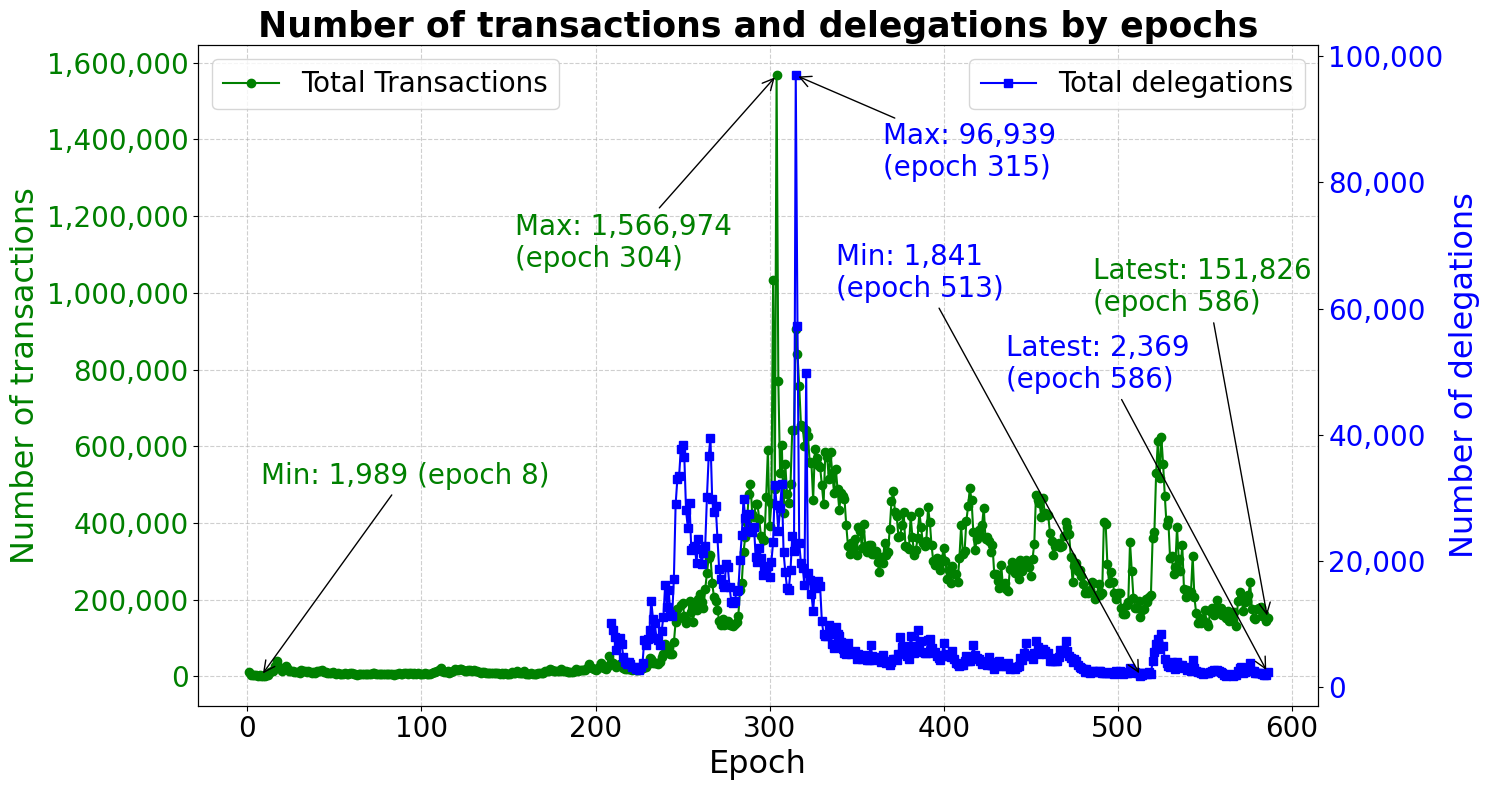

In [129]:
import numpy as np

fig, ax1 = plt.subplots(figsize=(15, 8))

x1 = np.arange(len(all_tx_fil['tx_count']))
y1 = np.array(all_tx_fil['tx_count'])

color = 'green'
ax1.plot(all_tx_fil['epoch_no'], all_tx_fil['tx_count'], marker='o', linestyle='-', color=color, label='Total Transactions')

ax1.set_xlabel('Epoch', fontsize=23)
ax1.set_ylabel('Number of transactions', color=color, fontsize=23)
ax1.tick_params(axis='both', labelsize=20)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

min_all_tx_count = all_tx_fil['tx_count'].min()
max_all_tx_count = all_tx_fil['tx_count'].max()
min_all_tx_epoch = all_tx_fil.loc[all_tx_fil['tx_count'].idxmin(), 'epoch_no']
max_all_tx_epoch = all_tx_fil.loc[all_tx_fil['tx_count'].idxmax(), 'epoch_no']
current_all_tx_epoch = all_tx_fil['epoch_no'].max()
current_all_tx_count = all_tx_fil.loc[all_tx_fil['epoch_no'].idxmax(), 'tx_count']

ax1.annotate(f'Min: {min_all_tx_count:,} (epoch {min_all_tx_epoch})',
             xy=(min_all_tx_epoch, min_all_tx_count), 
             xytext=(min_all_tx_epoch, min_all_tx_count + 500000),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')
ax1.annotate(f'Max: {max_all_tx_count:,} \n(epoch {max_all_tx_epoch})',
             xy=(max_all_tx_epoch, max_all_tx_count), 
             xytext=(max_all_tx_epoch - 150, max_all_tx_count - 500000),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')
ax1.annotate(f'Latest: {current_all_tx_count:,} \n(epoch {current_all_tx_epoch})',
             xy=(current_all_tx_epoch, current_all_tx_count), 
             xytext=(current_all_tx_epoch - 100 , current_all_tx_count + 800000),  
             arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=20, color='green')

ax2 = ax1.twinx()
color = 'blue'

x2 = np.arange(len(del_tx_fil['del_tx_count']))
y2 = np.array(del_tx_fil['del_tx_count'])

ax2.plot(del_tx_fil['epoch_no'], del_tx_fil['del_tx_count'], marker='s', linestyle='-', color=color, label='Total delegations')
ax2.set_ylabel('Number of delegations', color=color, fontsize=23)
ax2.tick_params(axis='y', labelcolor=color, labelsize=20)

min_del_tx_count = del_tx_fil['del_tx_count'].min()
max_del_tx_count = del_tx_fil['del_tx_count'].max()
min_del_tx_epoch = del_tx_fil.loc[del_tx_fil['del_tx_count'].idxmin(), 'epoch_no']
max_del_tx_epoch = del_tx_fil.loc[del_tx_fil['del_tx_count'].idxmax(), 'epoch_no']
current_del_tx_epoch = del_tx_fil['epoch_no'].max()
current_del_tx_count = del_tx_fil.loc[del_tx_fil['epoch_no'].idxmax(), 'del_tx_count']

ax2.annotate(f'Min: {min_del_tx_count:,} \n(epoch {min_del_tx_epoch})',
             xy=(min_del_tx_epoch, min_del_tx_count), 
             xytext=(min_del_tx_epoch-175, min_del_tx_count + 60000),  
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=20, color='blue')
ax2.annotate(f'Max: {max_del_tx_count:,} \n(epoch {max_del_tx_epoch})',
             xy=(max_del_tx_epoch, max_del_tx_count), 
             xytext=(max_del_tx_epoch + 50, max_del_tx_count - 16000),  
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=20, color='blue')
ax2.annotate(f'Latest: {current_del_tx_count:,} \n(epoch {current_del_tx_epoch})',
             xy=(current_del_tx_epoch, current_del_tx_count), 
             xytext=(current_del_tx_epoch - 150, current_del_tx_count + 45000),  
             arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=20, color='blue')

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title('Number of transactions and delegations by epochs', fontsize=25, fontweight='bold')
ax1.legend(loc='upper left', fontsize=20)
ax2.legend(loc='upper right', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.tight_layout()

plt.show()

<h2>Saturation threshold by epoch</h2>

In [ ]:
cur.execute("SELECT epoch_no, sum(saturation_point)/ 1000000 as total_active_stake FROM epoch_summary ORDER BY epoch_no;")